In [241]:
from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO
from Bio.SeqUtils import seq1


import pickle
import os
from os import path
from os.path import isfile, join, dirname, isdir, exists

from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as linalg
from scipy import sparse
import scipy.signal

import math



def getUnweightedLaplacianEigsDense(W):
    D = sparse.dia_matrix((W.sum(1).flatten(), 0), W.shape).toarray()
    L = D - W
    try:
        _, v = linalg.eigh(L)
    except:
        return np.zeros_like(W)
    return v

def get_csm(X, Y):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(Y.shape) == 1:
        Y = Y[:, None]
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)


def csm_to_binary(D, kappa):
    N = D.shape[0]
    M = D.shape[1]
    if kappa == 0:
        return np.ones_like(D)
    elif kappa < 1:
        NNeighbs = int(np.round(kappa*M))
    else:
        NNeighbs = kappa
    J = np.argpartition(D, NNeighbs, 1)[:, 0:NNeighbs]
    I = np.tile(np.arange(N)[:, None], (1, NNeighbs))
    V = np.ones(I.size)
    [I, J] = [I.flatten(), J.flatten()]
    ret = sparse.coo_matrix((V, (I, J)), shape=(N, M), dtype=np.uint8)
    return ret.toarray()

def csm_to_binary_mutual(D, kappa):
    return csm_to_binary(D, kappa)*(csm_to_binary(D.T, kappa).T)

def sliding_window(dist, win):
    N = D.shape[0]
    dist_stack = np.zeros((N-win+1, N-win+1))
    for i in range(0, win):
        dist_stack += dist[i:i+N-win+1, i:i+N-win+1]
    for i in range(N-win+1):
        dist_stack[i, i] = 0
    return dist_stack

def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir


def make_path(*argv):
    mypath = path.join(*argv)
    if not path.exists(dirname(mypath)):
        make_dir(*argv[:-1])
    return mypath    

In [310]:
with open('pickles/LRRPred_validation.pickle', 'rb') as handle:
    LRR_d = pickle.load(handle)

df = pd.read_excel('FileS1.xlsx', skiprows = 9)

code_l = []
for ii in range(df.shape[0]):
    if ii%2:
        code = df.iloc[ii]['PDB ID + chain']
        code_l.append(code)


In [311]:
code_l.index('4EZGA')

83

In [312]:
for ii in range(df.shape[0]):        
    if ii%2:
        motif_indices = []
        code = df.iloc[ii]['PDB ID + chain']
        if code.startswith('4NKGA'):
            print(code)
            pdb_code = code[:4]
            chain_id = code[4]
            entry = df.iloc[ii-1]['entry']
            motifs = df.iloc[ii]['entry']   
            for jj, char in enumerate(motifs):
                if char != '-':
                    motif_indices.append(jj)
            diff = [second - first for first, second in zip(motif_indices, motif_indices[1:])]
            print(motif_indices)
            motif_indices_d[code] = motif_indices
            if diff:
                avgper = np.mean(diff)    
                if math.isnan(avgper):        
                    avgper_d[code] = 'none'
                else:
                    avgper_d[code] = round(avgper)
            else:
                avgper_d[code]  = 'no motifs'
            break

4NKGA
[35, 56, 76, 97, 117, 137, 157, 177, 200, 226]


In [307]:
motif_indices_d[code]

[35, 56, 76, 97, 117, 137, 157, 177, 200, 226]

In [180]:

if False:
    avgper_d = {}
    motif_indices_d = {}
    for ii in range(df.shape[0]):        
        if ii%2:
            motif_indices = []
            code = df.iloc[ii]['PDB ID + chain']
            pdb_code = code[:4]
            chain_id = code[4]
            entry = df.iloc[ii-1]['entry']
            motifs = df.iloc[ii]['entry']   
            for jj, char in enumerate(motifs):
                if char != '-':
                    motif_indices.append(jj)
            diff = [second - first for first, second in zip(motif_indices, motif_indices[1:])]
            motif_indices_d[code] = motif_indices
            if diff:
                avgper = np.mean(diff)    
                if math.isnan(avgper):        
                    avgper_d[code] = 'none'
                else:
                    avgper_d[code] = round(avgper)
            else:
               avgper_d[code]  = 'no motifs'

In [4]:
# io = PDBIO()
# for code, val in LRR_d.items():
#     locs,chain = val
#     io.set_structure(chain)
#     io.save(make_path('pdb', 'validation_chains', code+'.pdb'))

In [194]:
if True:
    skipped = []
    LRR_bnd_l = {}

    for code in code_l:
        motifLocs = LRR_d[code]
        period = avgper_d[code]

        if type(period) != int:
            print('no motifs', code)
            skipped.append(code)
            continue
            parser = PDBParser()
            structure = parser.get_structure(code, "pdb/validation_chains/%s.pdb"%code)

            chain = list(structure.get_chains())[0]

            csvpath = make_path('csv', 'validation', '%s.csv'%code)
            alpha_carbons = []
            for atom in chain.get_atoms():
                if atom.id == 'CA':
                    alpha_carbons.append(np.array(list(atom.get_vector())))
                    
            X = np.array(alpha_carbons)
            np.savetxt(csvpath, X, delimiter=',')

            #print out the number of residues in the chain, and print the locations of the LRR motif residues

            a = motif_indices[0]
            b = motif_indices[-1]

            a = 31
            b = 216

            LRR_bnd_l[code]=(a,b)

            try:
                X = X[a: b, :]
            except:
                print('bad LRR boundaries', code)
            if X.shape[0] < 50:
                print('too short', code, X.shape[0])
            print(X.shape)
            D = get_csm(X, X)
            # Clean up the matrix a bit by doing a sliding window of length roughly the period
            D = sliding_window(D, period)
            # Clean up the matrix even more by binarizing it with nearest neighbors
            B = csm_to_binary_mutual(D, 20)
            #B = B[0:400, 0:400]
            v = getUnweightedLaplacianEigsDense(1-B)
            with open('npy/validation_eigenmatrix/%s.npy'%code, 'wb') as f:
                np.save(f, v[:, 0:29])

            plt.figure(figsize=(18, 6))
            plt.subplot(131)
            plt.imshow(D, cmap='magma_r')
            plt.title("Self-Similarity Matrix")
            plt.subplot(132)
            plt.imshow(B)
            plt.title("Binarized Self-Similarity Matrix")
            plt.subplot(133)
            plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
            plt.title("Eigenvectors of Unweighted Graph Laplacian")
            plt.savefig('plots/validation_eigenmatrix/%s.png'%code)
            # plt.show()
            plt.close()
            
            break  




(185, 3)


In [309]:
motif_indices_d[code]

KeyError: '4NKGA'

In [385]:
code = '5XWUB'

motif_indices = motif_indices_d[code]
period = avgper_d[code]

parser = PDBParser()
structure = parser.get_structure(code, "pdb/validation_chains/%s.pdb"%code)

chain = list(structure.get_chains())[0]


alpha_carbons = []
lb, ub = 46, 244
pdbseq = ''
for residue in chain.get_residues():
    resseq = residue.get_full_id()[3][1]
    if resseq in range(lb, ub):
        pdbseq += seq1(residue.get_resname())
        alpha_carbons.append(np.array(list(residue["CA"].get_vector())))

In [388]:
motif_indices = motif_indices_d[code]

In [386]:
pdbseq

'TLTMLCAKTGLLFVPPAIDRRVVELRLTDNFIAAVRRRDFANMTSLVHLTLSRNTIGQVAAGAFADLRALRALHLDSNRLAEVRGDQLRGLGNLRHLILGNNQIRKVESAAFDAFLSTVEDLDLSYNNLEALPWEAVGQMVNLNTLTLDHNLIDHIAEGTFVQLHKLVRLDMTSNRLHKLPPDGLFL'

In [345]:
pdbseq.find('VTSLAVY')

20

In [373]:
motif_indices

[1, 26, 50, 102, 125, 147, 169, 177]

In [387]:
# motif_indices = motif_indices[:-3]

In [389]:
        
#print out the number of residues in the chain, and print the locations of the LRR motif residues

a = 0
b = len(alpha_carbons)

# a = 0
# b = X.shape[0]

LRR_bnd_l[code]=(a,b)

try:
    X = X[a: b, :]
except:
    print('bad LRR boundaries', code)
if X.shape[0] < 50:
    print('too short', code, X.shape[0])
print(X.shape)

csvpath = make_path('csv', 'validation', '%s.csv'%code)
np.savetxt(csvpath, X, delimiter=',')
X = np.array(alpha_carbons)

D = get_csm(X, X)
# Clean up the matrix a bit by doing a sliding window of length roughly the period
D = sliding_window(D, period)
# Clean up the matrix even more by binarizing it with nearest neighbors
B = csm_to_binary_mutual(D, 20)
#B = B[0:400, 0:400]
v = getUnweightedLaplacianEigsDense(1-B)
with open('npy/validation_eigenmatrix/%s.npy'%code, 'wb') as f:
    np.save(f, v[:, 0:29])

plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(D, cmap='magma_r')
plt.title("Self-Similarity Matrix")
plt.subplot(132)
plt.imshow(B)
plt.title("Binarized Self-Similarity Matrix")
plt.subplot(133)
plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
plt.title("Eigenvectors of Unweighted Graph Laplacian")
plt.savefig('plots/validation_eigenmatrix/%s.png'%code)
# plt.show()
plt.close()

(173, 3)


25
[13, 34, 58, 82, 106, 131, 155, 179, 211]


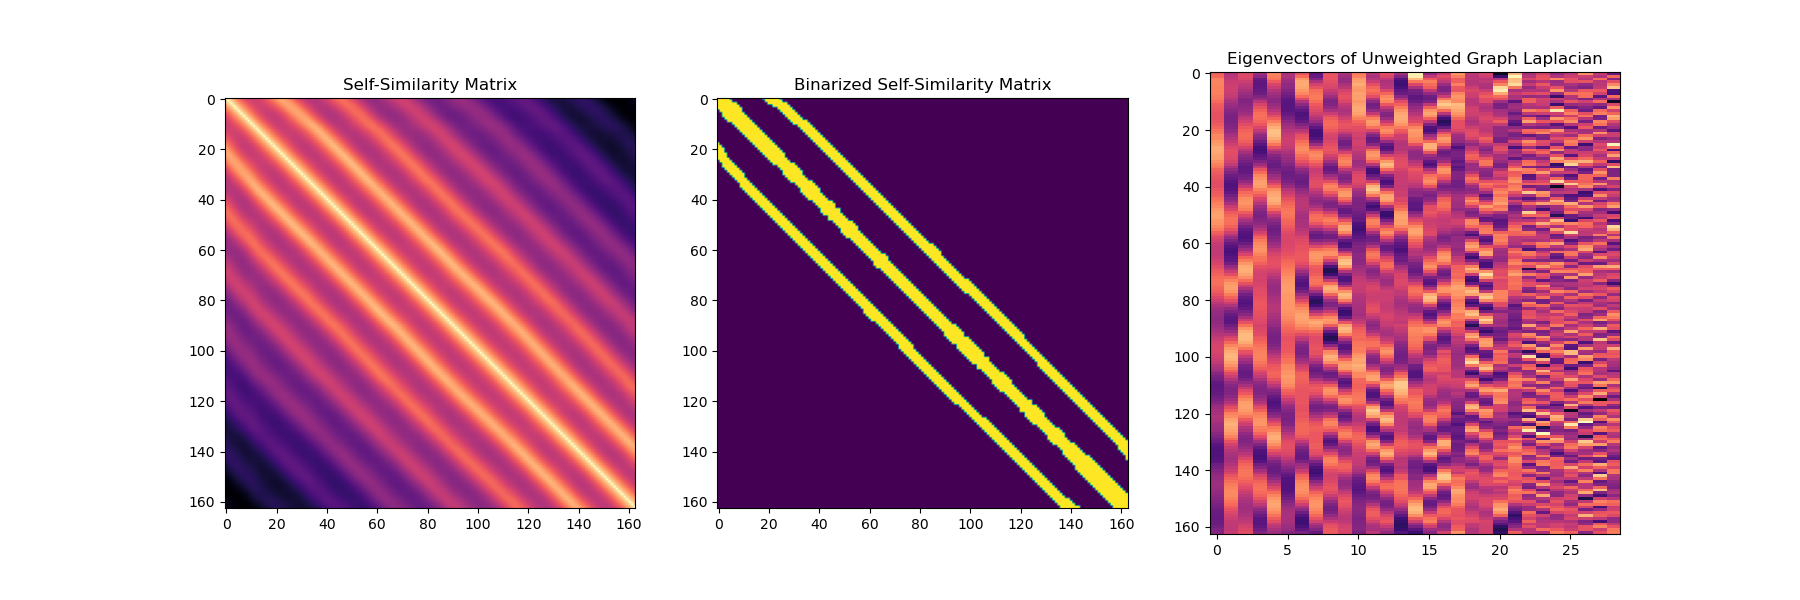

In [390]:
# code = '6GYUA'
period = avgper_d[code]
print(period)
print(motif_indices)
Image(filename='plots/validation_eigenmatrix/%s.png'%code)

0 187


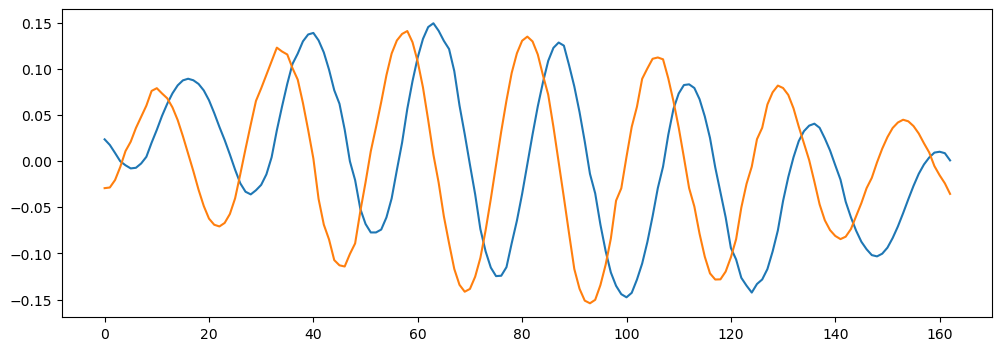

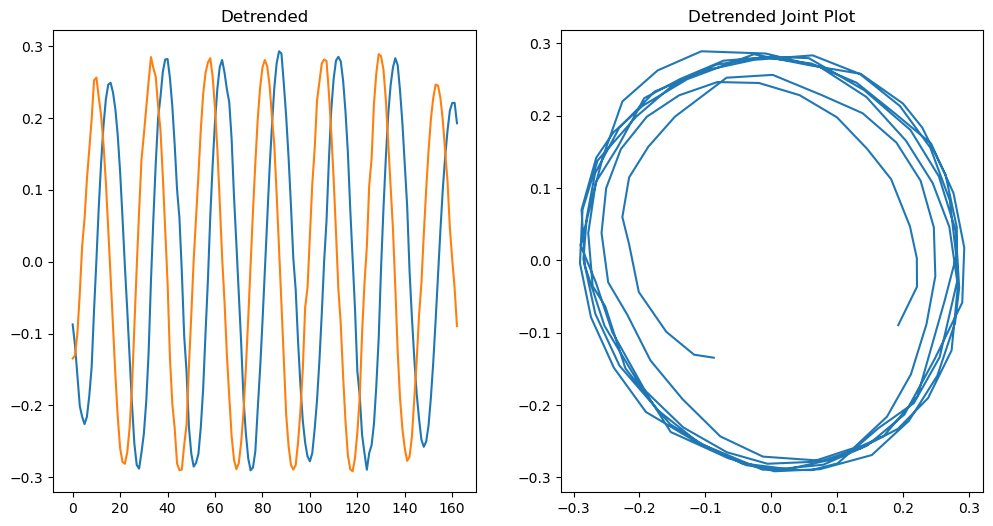

[13, 34, 58, 82, 106, 131, 155] [179, 211]


/var/folders/m0/rpw4gcbn5lxd8_3kt7g699rc0000gn/T/ipykernel_45757/746495732.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(motifloc, theta[motifloc], 'bo', color='red')


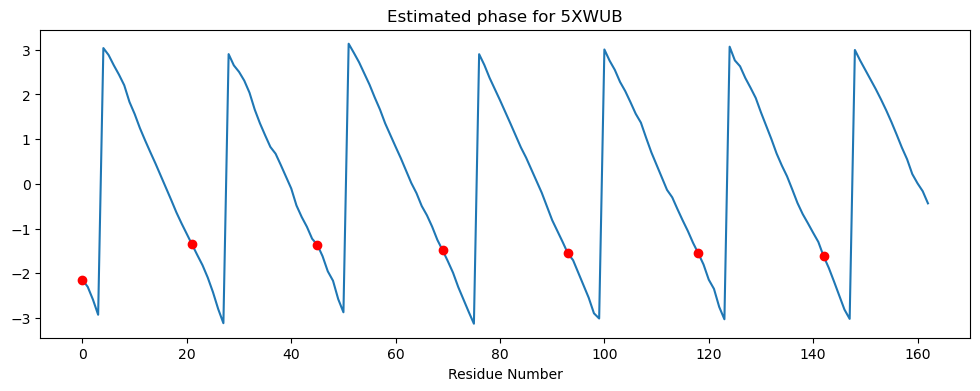

<function matplotlib.pyplot.close(fig=None)>

In [391]:

eig1,eig2 = 1,2

motifStart = 0

print(a,b)
v = np.load('npy/validation_eigenmatrix/%s.npy'%code)

plt.figure(figsize=(12, 4))
s = v[:,eig1]
c = v[:, eig2]
plt.plot(s)
plt.plot(c)
plt.show()
from daps import *
# Detrend with daps
sf = detrend_timeseries(s, period)
cf = detrend_timeseries(c, period)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(sf)
plt.plot(cf)
plt.title("Detrended")
plt.subplot(122)
plt.title("Detrended Joint Plot")
plt.plot(sf, cf)
plt.show()

# Extract the final phase and plot

theta = np.arctan2(cf, sf)
plt.figure(figsize=(12, 4))
plt.plot(theta)

phases = []
ommitted =[]
plotted_motifs = []
for res in motif_indices:
    motifloc = res-motifStart-motif_indices[0]
    if motifloc<len(theta):
        plt.plot(motifloc, theta[motifloc], 'bo', color='red')
        phases.append(theta[motifloc])
        plotted_motifs.append(res)
    else:
        ommitted.append(res)
        phases.append(-4)

phases = np.array(phases)


plt.title("Estimated phase for %s" %code)
plt.xlabel("Residue Number")
plt.savefig(make_path('plots','validation/%s.png'%code))

np.save(make_path('npy','validation_phase', '%s.npy'%code), phases)
np.save(make_path('npy','validation_theta', '%s.npy'%code), theta)
np.save(make_path('npy','validation_plotted_motifs', '%s.npy'%code), np.array(plotted_motifs))
print(plotted_motifs, ommitted)

plt.show()
plt.close

In [8]:
phases = np.load('npy/validation_phase/'+code+'.npy')
phases

array([ 1.49526834,  1.43509799,  1.49325906,  1.35833376,  1.3975735 ,
        1.49889346, -4.        , -4.        ])

In [9]:


df_per = pd.DataFrame(avgper_d.values(), code_l)
df_per.to_excel("avgper.xlsx") 
df_per

,0
1A9NA,24
1H6UA,22
1IO0A,29
1JL5A,21
1O6VA,22
...,...
6MLXA,24
6NPYA,no motifs
6O60C,26
6OBPC,22


In [10]:
df_perold = pd.read_excel('eigselection.xlsx')

In [11]:
rerun = []

for ii, (a, b) in enumerate(zip(avgper_d.values(),list(df_perold['estimated period']))):
    if a != b and type(a)==int:
        rerun.append(code_l[ii])
        print(ii, a, b)

28 29 42
39 25 24
65 28 -4
68 26 25
76 24 60
79 27 26
83 23 29
84 25 24
87 24 27
91 25 -2
112 28 26
116 24 14
122 23 7
128 25 28
134 22 21
138 24 30
141 28 27
148 25 -1
156 34 30
171 26 25


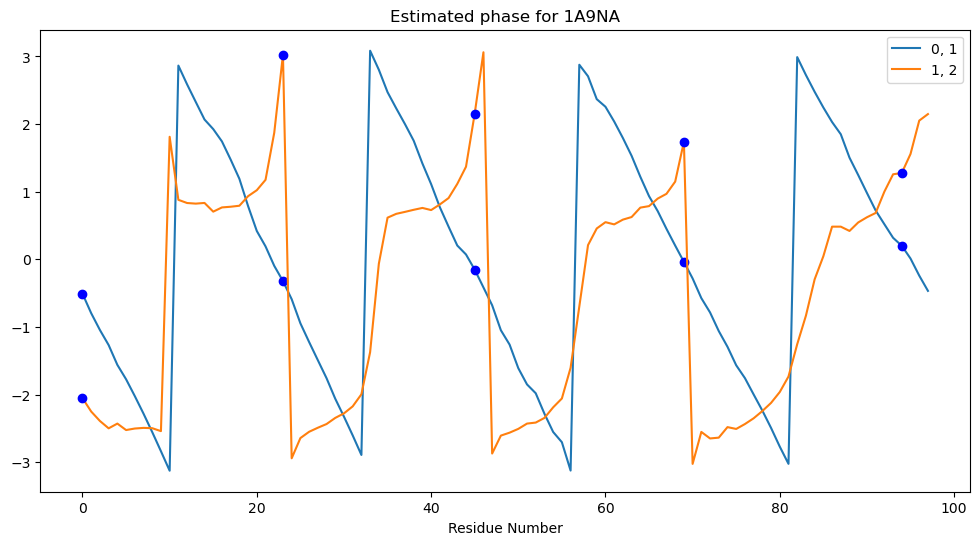

FileNotFoundError: [Errno 2] No such file or directory: 'plots/validation_autonomous/1A9NA.png'

<Figure size 640x480 with 0 Axes>

In [27]:
names = ["1A9NA", "1H6UA", "1IO0A", "1JL5A", "1O6VA", "1OGQA", "1OZNA", "1P9AG", "1PGVA", "1W8AA", "1WWLA", "1XEUA", "1XKUA", "1ZIWA", "2ASTB", "2BNHA", "2CA6A", "2ELLA", "2FT3A", "2ID5A", "2IFGA", "2JQDA", "2O6QA", "2O6RA", "2O6SA", "2P1MB", "2Q4GW", "2R9UA", "2RA8A", "2V70A", "2V9TB", "2WFHA", "2XOTA", "2XWTC", "2Z62A", "2Z63A", "2Z66A", "2Z7XA", "2Z7XB", "2Z80A", "2Z81A", "3A79B", "3B2DA", "3BZ5A", "3CIGA", "3E4GA", "3E6JA", "3G06A", "3G39A", "3GOZA", "3J0AA", "3JB9J", "3M19A", "3O53A", "3O6NA", "3OGKB", "3RFJA", "3RFSA", "3RG1A", "3RGZA", "3RW6A", "3SB4A", "3T6QA", "3TSRE", "3TWID", "3UN9A", "3V44A", "3VQ2A", "3WN4A", "3WO9A", "3WPEA", "3ZYIA", "3ZYJA", "3ZYOA", "4ARNA", "4AY9X", "4B8CD", "4BV4R", "4CILA", "4CNMA", "4CP6A", "4ECNA", "4ECOA", "4EZGA", "4FCGA", "4FD0A", "4FDWA", "4FS7A", "4G8AA", "4GLPA", "4GT6A", "4H09A", "4I6JB", "4IM6A", "4K5UA", "4KXFB", "4L3FA", "4LXRA", "4MN8A", "4MN8B", "4NKGA", "4OJUA", "4OW2A", "4P8SA", "4PBVA", "4PEQB", "4PERA", "4PKIG", "4PO4A", "4PQ8A", "4PSJA", "4Q3IA", "4Q62A", "4QDHA", "4QXEA", "4R58A", "4R6FA", "4R6GA", "4RCAB", "4RWTC", "4TZHA", "4U06A", "4U08A", "4U09A", "4UFRA", "4V2EA", "4XA9A", "4XGOA", "4XSQA", "4Y61B", "4Z5WA", "4Z63A", "4Z79A", "4Z8GA", "5B0NA", "5D3IA", "5GR8A", "5HL3A", "5HZLB", "5IRNA", "5JFKA", "5JH5A", "5KZSA", "5LFNA", "5MX0A", "5WLSA", "5XJOA", "5XKNA", "5XWUB", "5Y30A", "5Y9WA", "5YQ5A", "5YUDA", "5YXMA", "5Z8XA", "5ZB2A", "6BRPB", "6BXAC", "6BXEA", "6DBGA", "6EJXA", "6F4JA", "6FG7A", "6FG8A", "6FG8B", "6FNWA", "6G3WA", "6GFFI", "6GYUA", "6IF5A", "6J5TC", "6J6GB", "6K2DB", "6MLXA", "6NPYA", "6O60C", "6OBPC", "6R1HA"]

for code in names:
    
    try:
        motif_indices = motif_indices_d[code]
    except:
        continue
        
    if not motif_indices:
        continue
        
    motifLocs = LRR_d[code]
    period = avgper_d[code]
    # print(period)
    # print(motifLocs)
    # print(motif_indices)
    # Image(filename='plots/validation_eigenmatrix/%s.png'%code)
    
    plt.figure(figsize = (12,6))
    for eig1, eig2 in [(0,1), (1,2)]:
        if code in LRR_bnd_l.keys():
            a,b = LRR_bnd_l[code]
        else:
            a, b = motifLocs[0], motifLocs[-1]
        # print(a,b)
        v = np.load('npy/validation_eigenmatrix/%s.npy'%code)

        # plt.figure(figsize=(12, 4))
        s = v[:,eig1]
        c = v[:, eig2]
        # plt.plot(s)
        # plt.plot(c)
        # plt.show()
        # from daps import *
        # Detrend with daps
        sf = detrend_timeseries(s, period)
        cf = detrend_timeseries(c, period)

        # plt.figure(figsize=(12, 6))
        # plt.subplot(121)
        # plt.plot(sf)
        # plt.plot(cf)
        # plt.title("Detrended")
        # plt.subplot(122)
        # plt.title("Detrended Joint Plot")
        # plt.plot(sf, cf)
        # plt.show()

        # Extract the final phase and plot

        theta = np.arctan2(cf, sf)
        # plt.figure(figsize=(12, 4))
        plt.plot(theta, label=f'{eig1}, {eig2}')

        phases = []
        ommitted =[]
        plotted_motifs = []
        for res in motif_indices:
            if res-a<len(theta):
                plt.plot(res-a, theta[res-a], 'bo')
                phases.append(theta[res-a])
                plotted_motifs.append(res)
            else:
                ommitted.append(res)
                phases.append(-4)

        phases = np.array(phases)


        plt.title(f"Estimated phase for {code}")
        plt.legend()
        plt.xlabel("Residue Number")

#         np.save(make_path('npy','validation_phase', '%s.npy'%code), phases)
#         np.save(make_path('npy','validation_theta', '%s.npy'%code), theta)
#         np.save(make_path('npy','validation_plotted_motifs', '%s.npy'%code), np.array(plotted_motifs))
        # print(plotted_motifs, ommitted)

    plt.show()
    plt.savefig(make_path('plots','validation_autonomous/%s.png'%code))

    plt.close